ΕΙΣΑΓΩΓΗ ΒΙΒΛΙΟΘΗΚΩΝ

In [1]:
import pandas as pd         # Για εύκολο χειρισμό και ανάλυση πινάκων δεδομένων (DataFrames)
import numpy as np          # Για αριθμητικούς υπολογισμούς, ειδικά με arrays
import matplotlib.pyplot as plt # Για να φτιάχνουμε γραφήματα και να βλέπουμε τα δεδομένα
import seaborn as sns       # Βιβλιοθήκη για πιο όμορφα και προηγμένα γραφήματα
from sklearn.preprocessing import StandardScaler # Για την κλιμάκωση (scaling) αριθμητικών δεδομένων
from sklearn.model_selection import train_test_split

# Ρυθμίζουμε τα γραφήματα να είναι πιο ευανάγνωστα
sns.set_style("whitegrid")  # Λευκό φόντο με πλέγμα για τα γραφήματα
plt.rcParams['figure.figsize'] = (10, 6) # Προκαθορισμένο μέγεθος για τα γραφήματα

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Κελί 2: Φόρτωση & Καθαρισμός Δεδομένων

# Φόρτωση του αρχείου CSV
try:
    df = pd.read_csv('application_record.csv')
    print("Το αρχείο application_record.csv φορτώθηκε επιτυχώς!")
except FileNotFoundError:
    print("Σφάλμα: Το αρχείο application_record.csv δεν βρέθηκε. Βεβαιωθείτε ότι βρίσκεται στον ίδιο φάκελο.")
    exit()

# Συμπλήρωση ελλειπουσών τιμών στην 'OCCUPATION_TYPE' με 'Unknown'
if 'OCCUPATION_TYPE' in df.columns:
    df['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

# Αφαίρεση διπλότυπων IDs
df.drop_duplicates(subset='ID', keep='first', inplace=True)

Το αρχείο application_record.csv φορτώθηκε επιτυχώς!


<ipython-input-42-4054736724>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)


In [ ]:
# Κελί 3: Μηχανική Χαρακτηριστικών

# Ηλικία σε Χρόνια (AGE_YEARS) από DAYS_BIRTH
df['AGE_YEARS'] = np.abs(df['DAYS_BIRTH']) / 365.25

# Χρόνια Απασχόλησης (YEARS_EMPLOYED) από DAYS_EMPLOYED
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: np.abs(x) / 365.2425 if x != 365243 else 0)

# Εισόδημα ανά Μέλος Οικογένειας (INCOME_PER_FAMILY_MEMBER)
df['INCOME_PER_FAMILY_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df.replace([np.inf, -np.inf], np.nan, inplace=True) # Αντικαθιστά άπειρο με κενό
df['INCOME_PER_FAMILY_MEMBER'].fillna(0, inplace=True) # Συμπληρώνει κενά με 0

# Αναλογία Απασχόλησης προς Ηλικία (EMPLOYMENT_AGE_RATIO)
df['EMPLOYMENT_AGE_RATIO'] = df.apply(lambda row: row['YEARS_EMPLOYED'] / row['AGE_YEARS'] if row['AGE_YEARS'] > 0 else 0, axis=1)

<ipython-input-43-943299731>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['INCOME_PER_FAMILY_MEMBER'].fillna(0, inplace=True) # Συμπληρώνει κενά με 0


In [ ]:
# Κελί 4: Κωδικοποίηση & Κλιμάκωση Δεδομένων

# Κωδικοποίηση Κατηγορικών Δεδομένων (Λέξεις σε Αριθμούς)
categorical_cols_for_encoding = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols_for_encoding, drop_first=True)

# Κλιμάκωση Δεδομένων (Όλοι οι Αριθμοί στην ίδια "Ζυγαριά")
columns_to_scale = df.select_dtypes(include=np.number).columns.tolist()
columns_to_scale = [col for col in columns_to_scale if col not in ['ID']] # Εξαιρούμε το ID
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
# Κελί 5: Δημιουργία & Κωδικοποίηση Μεταβλητής Στόχου (RISK_LEVEL)

# Υπολογίζουμε τα όρια για τις κατηγορίες ρίσκου βασισμένα σε ποσοστιαία σημεία εισοδήματος
# Αυτό είναι ΠΡΟΣΩΡΙΝΟ και υποθετικό, αλλά θα διασφαλίσει την ύπαρξη όλων των κλάσεων!
# Π.χ., το 25% των πελατών με το χαμηλότερο εισόδημα είναι "Υψηλό Ρίσκο",
# το μεσαίο 50% είναι "Μεσαίο", και το 25% με το υψηλότερο είναι "Χαμηλό".
income_lower_bound = df['AMT_INCOME_TOTAL'].quantile(0.33)
income_upper_bound = df['AMT_INCOME_TOTAL'].quantile(0.66)

# Φτιάχνουμε τη συνταγή για το πώς θα υπολογίζεται το ρίσκο
def assign_risk_level(row):
    if row['AMT_INCOME_TOTAL'] < income_lower_bound:
        return 'Υψηλό Ρίσκο' # Εδώ βάζουμε τους πελάτες με χαμηλότερο εισόδημα
    elif row['AMT_INCOME_TOTAL'] >= income_lower_bound and row['AMT_INCOME_TOTAL'] < income_upper_bound:
        return 'Μεσαίο Ρίσκο' # Εδώ βάζουμε τους πελάτες με μεσαίο εισόδημα
    else:
        return 'Χαμηλό Ρίσκο' # Εδώ βάζουμε τους πελάτες με υψηλότερο εισόδημα

# Εφαρμόζουμε τη συνταγή σε κάθε πελάτη για να φτιάξουμε τη στήλη 'RISK_LEVEL'
df['RISK_LEVEL'] = df.apply(assign_risk_level, axis=1)

# Μετατρέπουμε το κείμενο του ρίσκου σε αριθμούς (0, 1, 2) για να το καταλάβει το μοντέλο
risk_mapping = {
    'Χαμηλό Ρίσκο': 0,
    'Μεσαίο Ρίσκο': 1,
    'Υψηλό Ρίσκο': 2
}
df['RISK_LEVEL_ENCODED'] = df['RISK_LEVEL'].map(risk_mapping)

print("Κατανομή κατηγοριών ρίσκου μετά τη δημιουργία (πριν το διαχωρισμό):")
print(df['RISK_LEVEL_ENCODED'].value_counts())

Κατανομή κατηγοριών ρίσκου μετά τη δημιουργία (πριν το διαχωρισμό):
RISK_LEVEL_ENCODED
0    161397
1    155541
2    121572
Name: count, dtype: int64


In [ ]:
# Κελί 5: Δημιουργία & Κωδικοποίηση Μεταβλητής Στόχου (RISK_LEVEL)

# Υπολογίζουμε τα όρια για τις κατηγορίες ρίσκου βασισμένα σε ποσοστιαία σημεία εισοδήματος
# Αυτό είναι ΠΡΟΣΩΡΙΝΟ και υποθετικό, αλλά θα διασφαλίσει την ύπαρξη όλων των κλάσεων!
# Π.χ., το 25% των πελατών με το χαμηλότερο εισόδημα είναι "Υψηλό Ρίσκο",
# το μεσαίο 50% είναι "Μεσαίο", και το 25% με το υψηλότερο είναι "Χαμηλό".
income_lower_bound = df['AMT_INCOME_TOTAL'].quantile(0.33)
income_upper_bound = df['AMT_INCOME_TOTAL'].quantile(0.66)

# Φτιάχνουμε τη συνταγή για το πώς θα υπολογίζεται το ρίσκο
def assign_risk_level(row):
    if row['AMT_INCOME_TOTAL'] < income_lower_bound:
        return 'Υψηλό Ρίσκο' # Εδώ βάζουμε τους πελάτες με χαμηλότερο εισόδημα
    elif row['AMT_INCOME_TOTAL'] >= income_lower_bound and row['AMT_INCOME_TOTAL'] < income_upper_bound:
        return 'Μεσαίο Ρίσκο' # Εδώ βάζουμε τους πελάτες με μεσαίο εισόδημα
    else:
        return 'Χαμηλό Ρίσκο' # Εδώ βάζουμε τους πελάτες με υψηλότερο εισόδημα

# Εφαρμόζουμε τη συνταγή σε κάθε πελάτη για να φτιάξουμε τη στήλη 'RISK_LEVEL'
df['RISK_LEVEL'] = df.apply(assign_risk_level, axis=1)

# Μετατρέπουμε το κείμενο του ρίσκου σε αριθμούς (0, 1, 2) για να το καταλάβει το μοντέλο
risk_mapping = {
    'Χαμηλό Ρίσκο': 0,
    'Μεσαίο Ρίσκο': 1,
    'Υψηλό Ρίσκο': 2
}
df['RISK_LEVEL_ENCODED'] = df['RISK_LEVEL'].map(risk_mapping)

print("Κατανομή κατηγοριών ρίσκου μετά τη δημιουργία (πριν το διαχωρισμό):")
print(df['RISK_LEVEL_ENCODED'].value_counts())

Κατανομή κατηγοριών ρίσκου μετά τη δημιουργία (πριν το διαχωρισμό):
RISK_LEVEL_ENCODED
0    161397
1    155541
2    121572
Name: count, dtype: int64


In [ ]:
# Κελί 6: Διαχωρισμός σε X και y, και σε Training/Testing Sets

# X: Όλες οι πληροφορίες που θα δώσουμε στο μοντέλο για να μάθει (τα χαρακτηριστικά)
# Αφαιρούμε:
# - 'ID': Είναι απλά ένας αριθμός ταυτότητας, δεν βοηθά στην πρόβλεψη.
# - 'RISK_LEVEL': Η αρχική στήλη ρίσκου με κείμενο.
# - 'RISK_LEVEL_ENCODED': Αυτή είναι η απάντηση που θέλουμε να βρει το μοντέλο, όχι πληροφορία για πρόβλεψη.
X = df.drop(['ID', 'RISK_LEVEL', 'RISK_LEVEL_ENCODED'], axis=1)

# y: Η σωστή απάντηση που θέλουμε να προβλέψει το μοντέλο (το επίπεδο ρίσκου σε αριθμό)
y = df['RISK_LEVEL_ENCODED']

# Χωρίζουμε τα δεδομένα μας σε 80% για εκπαίδευση και 20% για δοκιμή
# test_size=0.2: Το 20% των δεδομένων θα χρησιμοποιηθεί για να δοκιμάσουμε το μοντέλο.
# random_state=42: Αυτός ο αριθμός εξασφαλίζει ότι ο χωρισμός είναι πάντα ο ίδιος, για να έχουμε σταθερά αποτελέσματα.
# stratify=y: ΠΟΛΥ ΣΗΜΑΝΤΙΚΟ! Εξασφαλίζει ότι η αναλογία των κατηγοριών ρίσκου (0, 1, 2)
#             θα είναι ίδια και στα δεδομένα εκπαίδευσης και στα δεδομένα δοκιμής.
#             Αυτό είναι κρίσιμο αν κάποιες κατηγορίες είναι σπάνιες.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nΚατανομή κατηγοριών ρίσκου στο y_train (εκπαίδευση):")
print(y_train.value_counts())
print("\nΚατανομή κατηγοριών ρίσκου στο y_test (δοκιμή):")
print(y_test.value_counts())


Κατανομή κατηγοριών ρίσκου στο y_train (εκπαίδευση):
RISK_LEVEL_ENCODED
0    129117
1    124433
2     97258
Name: count, dtype: int64

Κατανομή κατηγοριών ρίσκου στο y_test (δοκιμή):
RISK_LEVEL_ENCODED
0    32280
1    31108
2    24314
Name: count, dtype: int64


In [ ]:
# Κελί 7: Εκπαίδευση Random Forest

# Φτιάχνουμε τον "εγκέφαλο" Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Εκπαιδεύουμε τον Random Forest
model_rf.fit(X_train, y_train)

print("Ο Random Forest εκπαιδεύτηκε!")

Ο Random Forest εκπαιδεύτηκε!


In [ ]:
# Κελί 8: Εκπαίδευση Logistic Regression

# Φτιάχνουμε τον "εγκέφαλο" Logistic Regression
# Χρησιμοποιούμε solver='lbfgs' και multi_class='auto' για καλύτερη συμβατότητα και απόδοση.
# max_iter=1000 για να του δώσουμε αρκετό χρόνο να "μάθει".
model_lr = LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto', max_iter=1000)

# Εκπαιδεύουμε τον Logistic Regression
model_lr.fit(X_train, y_train)

print("Ο Logistic Regression εκπαιδεύτηκε!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Ο Logistic Regression εκπαιδεύτηκε!


In [ ]:
# Κελί 9: Εκπαίδευση SVM

# Φτιάχνουμε τον "εγκέφαλο" SVM
# kernel='linear' για να ψάξει για ευθείες γραμμές διαχωρισμού.
model_svm = SVC(kernel='linear', random_state=42)

# Εκπαιδεύουμε τον SVM
model_svm.fit(X_train, y_train)

print("Ο SVM εκπαιδεύτηκε!")

Ο SVM εκπαιδεύτηκε!


In [ ]:
# Κελί 10: Προβλέψεις

# Προβλέψεις με τον Random Forest
y_pred_rf = model_rf.predict(X_test)

# Προβλέψεις με τον Logistic Regression
y_pred_lr = model_lr.predict(X_test)

# Προβλέψεις με τον SVM
y_pred_svm = model_svm.predict(X_test)


--- Αξιολόγηση για το μοντέλο: Random Forest ---
Ακρίβεια (Accuracy): 1.0000

Αναφορά Ταξινόμησης:
              precision    recall  f1-score   support

Χαμηλό Ρίσκο       1.00      1.00      1.00     32280
Μεσαίο Ρίσκο       1.00      1.00      1.00     31108
 Υψηλό Ρίσκο       1.00      1.00      1.00     24314

    accuracy                           1.00     87702
   macro avg       1.00      1.00      1.00     87702
weighted avg       1.00      1.00      1.00     87702


Πίνακας Σύγχυσης:
[[32280     0     0]
 [    0 31108     0]
 [    0     0 24314]]


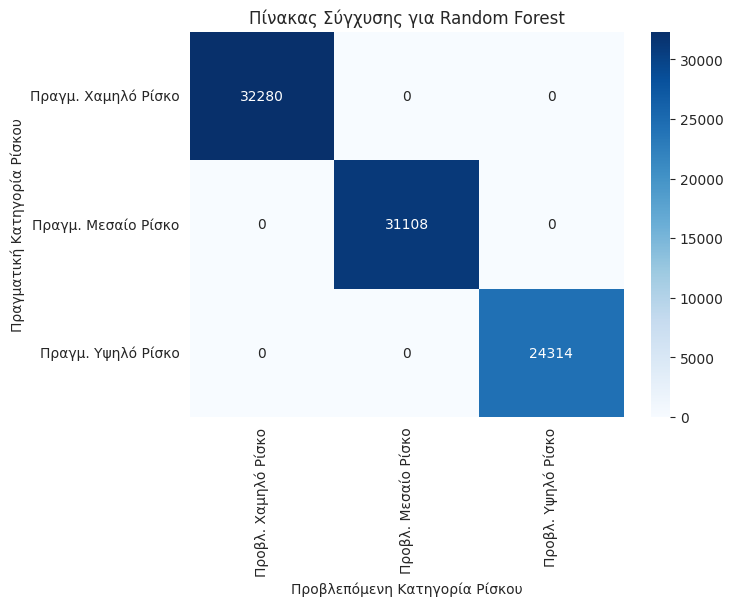


--- Αξιολόγηση για το μοντέλο: Logistic Regression ---
Ακρίβεια (Accuracy): 0.9944

Αναφορά Ταξινόμησης:
              precision    recall  f1-score   support

Χαμηλό Ρίσκο       1.00      1.00      1.00     32280
Μεσαίο Ρίσκο       0.99      0.99      0.99     31108
 Υψηλό Ρίσκο       1.00      0.99      0.99     24314

    accuracy                           0.99     87702
   macro avg       0.99      0.99      0.99     87702
weighted avg       0.99      0.99      0.99     87702


Πίνακας Σύγχυσης:
[[32280     0     0]
 [  147 30952     9]
 [    0   334 23980]]


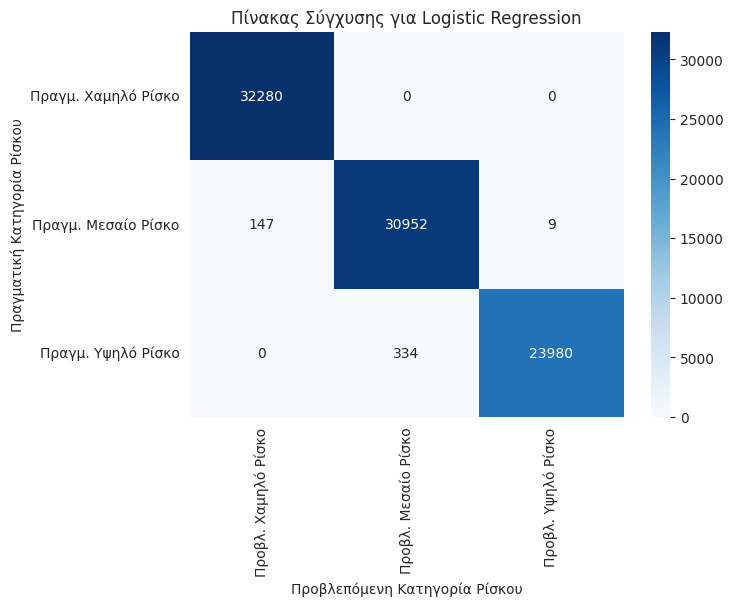


--- Αξιολόγηση για το μοντέλο: SVM ---
Ακρίβεια (Accuracy): 0.9996

Αναφορά Ταξινόμησης:
              precision    recall  f1-score   support

Χαμηλό Ρίσκο       1.00      1.00      1.00     32280
Μεσαίο Ρίσκο       1.00      1.00      1.00     31108
 Υψηλό Ρίσκο       1.00      1.00      1.00     24314

    accuracy                           1.00     87702
   macro avg       1.00      1.00      1.00     87702
weighted avg       1.00      1.00      1.00     87702


Πίνακας Σύγχυσης:
[[32280     0     0]
 [    6 31102     0]
 [    0    25 24289]]


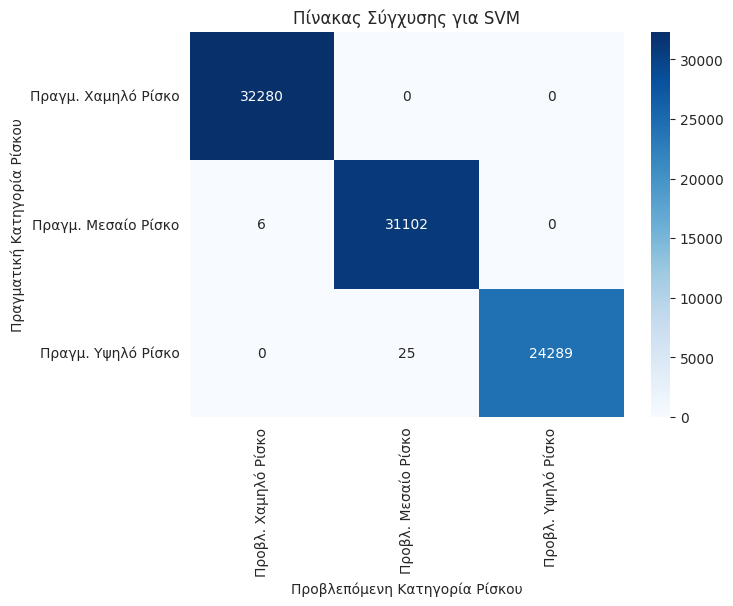


--- Η Αξιολόγηση Όλων των Μοντέλων Ολοκληρώθηκε ---


In [ ]:
# Κελί 11: Αξιολόγηση

# Ονομάζουμε τις κατηγορίες ρίσκου για καλύτερη ανάγνωση στις αναφορές μας
risk_names = ['Χαμηλό Ρίσκο', 'Μεσαίο Ρίσκο', 'Υψηλό Ρίσκο'] # Αυτά αντιστοιχούν σε 0, 1, 2

# Λίστα με τα μοντέλα και τις προβλέψεις τους για να τα ελέγξουμε όλα
models_to_evaluate = {
    "Random Forest": y_pred_rf,
    "Logistic Regression": y_pred_lr,
    "SVM": y_pred_svm
}

# Ελέγχουμε κάθε μοντέλο ένα-ένα
for model_name, y_pred in models_to_evaluate.items():
    print(f"\n--- Αξιολόγηση για το μοντέλο: {model_name} ---")

    # Ακρίβεια (Accuracy): Πόσο συχνά μαντεύει σωστά;
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Ακρίβεια (Accuracy): {accuracy:.4f}")

    # Αναλυτική Αναφορά Ταξινόμησης
    # Η παράμετρος 'labels' διασφαλίζει ότι θα εμφανιστούν όλες οι κατηγορίες (0, 1, 2),
    # ακόμα κι αν κάποια δεν προβλέφθηκε ή δεν υπήρχε στο y_test.
    print("\nΑναφορά Ταξινόμησης:")
    print(classification_report(y_test, y_pred, target_names=risk_names, labels=[0, 1, 2], zero_division='warn'))

    # Πίνακας Σύγχυσης
    # Ορίζουμε τα labels εδώ επίσης για να εμφανιστεί σωστά ο πίνακας για όλες τις κλάσεις.
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    print("\nΠίνακας Σύγχυσης:")
    print(conf_matrix)

    # Ζωγραφίζουμε τον Πίνακα Σύγχυσης
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Προβλ. {name}' for name in risk_names],
                yticklabels=[f'Πραγμ. {name}' for name in risk_names])
    plt.xlabel('Προβλεπόμενη Κατηγορία Ρίσκου')
    plt.ylabel('Πραγματική Κατηγορία Ρίσκου')
    plt.title(f'Πίνακας Σύγχυσης για {model_name}')
    plt.show()

print("\n--- Η Αξιολόγηση Όλων των Μοντέλων Ολοκληρώθηκε ---")